# Modeling Credit Risk with Lending Club data

### Outline

1. Business problem and summary of results
2. Data import.
3. Data preprocessing.
4. EDA.
5. Sample split, missing values and feature engineering.
6. Modeling.
7. Interpretation of the results.
8. Business implications.

#### Objective: Predict delinquency of a borrower
#### Metric: Precision at 20% Recall.

#### Business problem




#### Notes:

One big question about this data is which features are available at the origination time and are never updated afterwards. It seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.
I will use only features, known before loan issuance.

### Business Problem

### Objective

### Summary of Results

## 2. Data import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys, re
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [2]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [3]:
time0 = time.time()

with open('../input/lc-sample850k/LCLoans_sample850k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['id', 'loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'total_rev_hi_lim',               
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd',
 'recoveries']

df = df[features_tokeep]

recoveries = df[['id', 'recoveries', 'loan_amnt', 'int_rate']]

df.drop(columns = ['recoveries'], inplace=True)
df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later

df.issue_d = df.issue_d.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
#df = df[df.year_issued.isin([2018])]
    
df = df.sample(200000)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(200000, 68)

5.258471488952637

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued
0,102955868,Current,28000.0,28000.0,28000.0,60.0,16.99,695.729980,2017-04-01,small_business,Business,w,Individual,D,D1,689.0,President,4 years,MORTGAGE,120000.0,740xx,OK,17.709999,Source Verified,14.0,3.0,NaN,NaN,3.0,3.0,0.0,Jan-1999,0.0,2.0,0.0,11.0,3.0,0.0,13.0,6385.0,70232.0,12374.0,43.3,10817.0,15.0,6.0,7.0,28600.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,70232.0,0.0,0.0,0.000000,83.300003,0.0,0.0,0.0,0.0,0.0,0.0,2017.0
1,136468144,Fully Paid,5000.0,5000.0,5000.0,36.0,11.55,165.000000,2018-07-01,home_improvement,Home improvement,w,Individual,B,B4,679.0,Purchasing Agent,1 year,MORTGAGE,62000.0,300xx,GA,32.220001,Source Verified,3.0,60.0,60.0,NaN,60.0,60.0,5.0,Apr-1994,1.0,2.0,5.0,16.0,9.0,2.0,49.0,14137.0,212048.0,17844.0,81.1,1994.0,5.0,11.0,12.0,22000.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,46955.0,2577.0,0.0,62.500000,75.500000,3.0,2.0,0.0,0.0,0.0,7.0,2018.0
2,68681876,Charged Off,20000.0,20000.0,20000.0,60.0,14.85,474.230011,2016-01-01,debt_consolidation,Debt consolidation,w,Individual,C,C5,684.0,Project Manager,2 years,RENT,60000.0,770xx,TX,10.750000,Not Verified,16.0,9.0,9.0,NaN,24.0,9.0,0.0,Apr-1998,0.0,3.0,2.0,13.0,3.0,2.0,55.0,1806.0,23476.0,2221.0,32.7,4126.0,28.0,2.0,3.0,6800.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,23476.0,0.0,0.0,50.000000,83.599998,0.0,0.0,1.0,0.0,0.0,6.0,2016.0
3,73231432,Fully Paid,10000.0,10000.0,10000.0,36.0,11.99,332.100006,2016-02-01,credit_card,Credit card refinancing,w,Individual,C,C1,679.0,management,10+ years,RENT,60000.0,231xx,VA,10.540000,Source Verified,2.0,12.0,41.0,37.0,12.0,12.0,3.0,Mar-2000,1.0,0.0,1.0,7.0,3.0,0.0,20.0,1947.0,13631.0,5938.0,40.7,2660.0,2.0,6.0,6.0,14600.0,2.0,0.0,0.0,3.0,0.0,NaN,NaN,NaN,13631.0,71.0,1.0,33.299999,52.599998,1.0,2.0,0.0,0.0,0.0,0.0,2016.0
4,41339202,Fully Paid,25000.0,25000.0,25000.0,36.0,6.68,768.280029,2015-03-01,debt_consolidation,Debt consolidation,w,Individual,A,A3,744.0,Dir/Mar/sale,10+ years,OWN,210000.0,301xx,GA,2.990000,Source Verified,13.0,11.0,NaN,NaN,11.0,11.0,0.0,Jul-1999,0.0,NaN,NaN,20.0,4.0,21.0,55.0,45327.0,906531.0,157526.0,23.8,35680.0,23.0,5.0,12.0,203400.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,157526.0,0.0,0.0,11.100000,98.099998,NaN,NaN,0.0,0.0,0.0,0.0,2015.0


## 3. Data preprocessing

In [4]:
### feature description:

#f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
#f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
#display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])

In [5]:
# remove some very rarae loan types:

df = df[~df.purpose.isin(['educational', 'renewable_energy', 'wedding'])]
df.purpose = df.purpose.cat.remove_categories(['educational', 'renewable_energy', 'wedding'])


In [6]:
# clean time features

df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,102955868,Current,28000.0,28000.0,28000.0,60.0,16.99,695.729980,2017-04-01,small_business,Business,w,Individual,D,D1,689.0,President,4 years,MORTGAGE,120000.0,740xx,OK,17.709999,Source Verified,14.0,3.0,NaN,NaN,3.0,3.0,0.0,1999-01-01,0.0,2.0,0.0,11.0,3.0,0.0,13.0,6385.0,70232.0,12374.0,43.3,10817.0,15.0,6.0,7.0,28600.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,70232.0,0.0,0.0,0.000000,83.300003,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,4.0,2017.0,18.248150,0.000000
1,136468144,Fully Paid,5000.0,5000.0,5000.0,36.0,11.55,165.000000,2018-07-01,home_improvement,Home improvement,w,Individual,B,B4,679.0,Purchasing Agent,1 year,MORTGAGE,62000.0,300xx,GA,32.220001,Source Verified,3.0,60.0,60.0,NaN,60.0,60.0,5.0,1994-04-01,1.0,2.0,5.0,16.0,9.0,2.0,49.0,14137.0,212048.0,17844.0,81.1,1994.0,5.0,11.0,12.0,22000.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,46955.0,2577.0,0.0,62.500000,75.500000,3.0,2.0,0.0,0.0,0.0,7.0,2018.0,7.0,2018.0,24.249642,0.000000
2,68681876,Charged Off,20000.0,20000.0,20000.0,60.0,14.85,474.230011,2016-01-01,debt_consolidation,Debt consolidation,w,Individual,C,C5,684.0,Project Manager,2 years,RENT,60000.0,770xx,TX,10.750000,Not Verified,16.0,9.0,9.0,NaN,24.0,9.0,0.0,1998-04-01,0.0,3.0,2.0,13.0,3.0,2.0,55.0,1806.0,23476.0,2221.0,32.7,4126.0,28.0,2.0,3.0,6800.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,23476.0,0.0,0.0,50.000000,83.599998,0.0,0.0,1.0,0.0,0.0,6.0,2016.0,1.0,2016.0,17.752589,0.000000
3,73231432,Fully Paid,10000.0,10000.0,10000.0,36.0,11.99,332.100006,2016-02-01,credit_card,Credit card refinancing,w,Individual,C,C1,679.0,management,10+ years,RENT,60000.0,231xx,VA,10.540000,Source Verified,2.0,12.0,41.0,37.0,12.0,12.0,3.0,2000-03-01,1.0,0.0,1.0,7.0,3.0,0.0,20.0,1947.0,13631.0,5938.0,40.7,2660.0,2.0,6.0,6.0,14600.0,2.0,0.0,0.0,3.0,0.0,NaN,NaN,NaN,13631.0,71.0,1.0,33.299999,52.599998,1.0,2.0,0.0,0.0,0.0,0.0,2016.0,2.0,2016.0,15.920929,0.188431
4,41339202,Fully Paid,25000.0,25000.0,25000.0,36.0,6.68,768.280029,2015-03-01,debt_consolidation,Debt consolidation,w,Individual,A,A3,744.0,Dir/Mar/sale,10+ years,OWN,210000.0,301xx,GA,2.990000,Source Verified,13.0,11.0,NaN,NaN,11.0,11.0,0.0,1999-07-01,0.0,NaN,NaN,20.0,4.0,21.0,55.0,45327.0,906531.0,157526.0,23.8,35680.0,23.0,5.0,12.0,203400.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,157526.0,0.0,0.0,11.100000,98.099998,NaN,NaN,0.0,0.0,0.0,0.0,2015.0,3.0,2015.0,15.666304,0.000000


In [7]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             99090
Current                                                72800
Charged Off                                            25483
Late (31-120 days)                                      1071
In Grace Period                                          697
Late (16-30 days)                                        184
Does not meet the credit policy. Status:Fully Paid       150
Issued                                                   122
Default                                                   36
Does not meet the credit policy. Status:Charged Off       34
Name: loan_status, dtype: int64

(124609, 73)

Fully Paid                                             99090
Charged Off                                            25483
Default                                                   36
Current                                                    0
Does not meet the credit policy. Status:Charged Off        0
Does not meet the credit policy. Status:Fully Paid         0
In Grace Period                                            0
Issued                                                     0
Late (16-30 days)                                          0
Late (31-120 days)                                         0
Name: loan_status, dtype: int64

id                                124609
loan_status                       124609
loan_amnt                         124609
funded_amnt                       124609
funded_amnt_inv                   124609
term                              124609
int_rate                          124609
installment                       124609
issue_d                           124609
purpose                           124609
title                             123172
initial_list_status               124609
application_type                  124609
grade                             124609
sub_grade                         124609
fico_range_high                   124609
emp_title                         115958
emp_length                        116868
home_ownership                    124609
annual_inc                        124609
zip_code                          124609
addr_state                        124609
dti                               124550
verification_status               124609
mo_sin_rcnt_tl  

85.93312740325928

### 3. Feature Preprocessing

In [8]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc
df['total_rev_inc'] = df.total_rev_hi_lim/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df.loc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    41261
2.0     11155
0.0     10149
3.0     10139
1.0      8267
5.0      7689
4.0      7445
6.0      5718
8.0      5320
7.0      5206
9.0      4519
Name: emp_length, dtype: int64

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
1,136468144,5000.0,5000.0,5000.0,36.0,11.55,165.000000,home_improvement,Home improvement,w,Individual,B,B4,679.0,Purchasing Agent,1.0,MORTGAGE,62000.0,300,GA,32.220001,Source Verified,3.0,60.0,60.0,NaN,60.0,60.0,5.0,1.0,2.0,5.0,16.0,9.0,2.0,49.0,14137.0,212048.0,17844.0,81.1,1994.0,5.0,11.0,12.0,22000.0,0.0,0.0,0.0,0.0,0.0,46955.0,2577.0,0.0,62.500000,75.500000,3.0,2.0,0.0,0.0,0.0,7.0,2018.0,7.0,2018.0,24.249642,0.000000,0.0,0.080645,0.031935,0,0.287806,0.228016,3.420129,0.757339,0.354839,0,0.326531,0
2,68681876,20000.0,20000.0,20000.0,60.0,14.85,474.230011,debt_consolidation,Debt consolidation,w,Individual,C,C5,684.0,Project Manager,2.0,RENT,60000.0,770,TX,10.750000,Not Verified,16.0,9.0,9.0,NaN,24.0,9.0,0.0,0.0,3.0,2.0,13.0,3.0,2.0,55.0,1806.0,23476.0,2221.0,32.7,4126.0,28.0,2.0,3.0,6800.0,2.0,0.0,0.0,0.0,0.0,23476.0,0.0,0.0,50.000000,83.599998,0.0,0.0,1.0,0.0,0.0,6.0,2016.0,1.0,2016.0,17.752589,0.000000,1.0,0.333333,0.094846,0,0.037017,0.030100,0.391267,0.391267,0.113333,0,0.236364,0
3,73231432,10000.0,10000.0,10000.0,36.0,11.99,332.100006,credit_card,Credit card refinancing,w,Individual,C,C1,679.0,management,10.0,RENT,60000.0,231,VA,10.540000,Source Verified,2.0,12.0,41.0,37.0,12.0,12.0,3.0,1.0,0.0,1.0,7.0,3.0,0.0,20.0,1947.0,13631.0,5938.0,40.7,2660.0,2.0,6.0,6.0,14600.0,2.0,0.0,0.0,3.0,0.0,13631.0,71.0,1.0,33.299999,52.599998,1.0,2.0,0.0,0.0,0.0,0.0,2016.0,2.0,2016.0,15.920929,0.188431,0.0,0.166667,0.066420,0,0.098967,0.032450,0.227183,0.227183,0.243333,0,0.350000,0
4,41339202,25000.0,25000.0,25000.0,36.0,6.68,768.280029,debt_consolidation,Debt consolidation,w,Individual,A,A3,744.0,Dir/Mar/sale,10.0,OWN,210000.0,301,GA,2.990000,Source Verified,13.0,11.0,NaN,NaN,11.0,11.0,0.0,0.0,NaN,NaN,20.0,4.0,21.0,55.0,45327.0,906531.0,157526.0,23.8,35680.0,23.0,5.0,12.0,203400.0,1.0,0.0,0.0,0.0,0.0,157526.0,0.0,0.0,11.100000,98.099998,NaN,NaN,0.0,0.0,0.0,0.0,2015.0,3.0,2015.0,15.666304,0.000000,0.0,0.119048,0.043902,0,0.750124,0.215843,4.316814,0.750124,0.968571,0,0.363636,0
5,30245025,13000.0,13000.0,13000.0,60.0,18.24,331.820007,medical,Medical expenses,w,Individual,D,D5,709.0,Program Manager,5.0,RENT,65000.0,15,MA,26.940001,Source Verified,2.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,21.0,2.0,0.0,45.0,4016.0,84338.0,2745.0,70.4,1155.0,35.0,3.0,3.0,3900.0,0.0,0.0,0.0,0.0,0.0,84338.0,0.0,0.0,33.299999,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2014.0,10.0,2014.0,11.915371,0.000000,0.0,0.200000,0.061259,0,0.042231,0.061785,1.297508,1.297508,0.060000,0,0.466667,0


In [9]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



id                                124609
loan_amnt                         124609
funded_amnt                       124609
funded_amnt_inv                   124609
term                              124609
int_rate                          124609
installment                       124609
purpose                           124609
title                             123172
initial_list_status               124609
application_type                  124609
grade                             124609
sub_grade                         124609
fico_range_high                   124609
emp_title                         115958
emp_length                        116868
home_ownership                    124609
annual_inc                        124609
zip_code                          124609
addr_state                        124609
dti                               124550
verification_status               124609
mo_sin_rcnt_tl                    124609
mths_since_last_delinq            124609
mths_since_last_

In [10]:
df.mo_sin_rcnt_tl.describe()

count    124609.000000
mean         12.246266
std          22.862228
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         233.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [11]:
df.target.mean()

0.2047925912253529

In [12]:
cat_features_te = ['sub_grade', 'emp_title', 'purpose', 'title', 'zip_code', 'addr_state', 'grade', 'home_ownership']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [13]:
df.application_type.value_counts()

Individual    120142
Joint App       4467
Name: application_type, dtype: int64

### 4. EDA

In [14]:
print('Bankruptcy incidnce is the sample is: ', df.target.mean())

Bankruptcy incidnce is the sample is:  0.2047925912253529


In [15]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,124609.000000,124609.000000,124609.000000
mean,14451.028320,14445.223633,14426.819336
std,8959.958984,8957.291992,8958.564453
min,1000.000000,1000.000000,0.000000
25%,7500.000000,7500.000000,7500.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    95757
60.0    28852
Name: term, dtype: int64

So the three amount features above are basically identical.

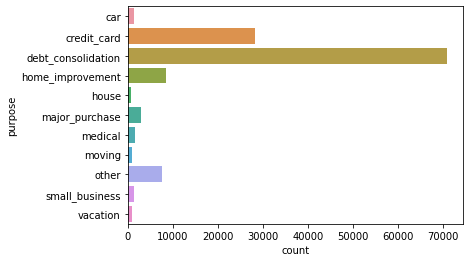

<AxesSubplot:xlabel='count', ylabel='emp_length'>

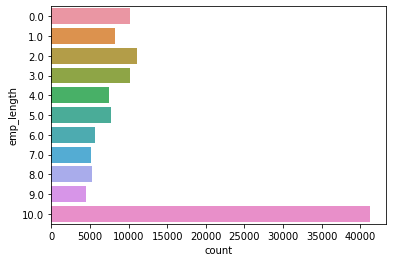

In [16]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [17]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

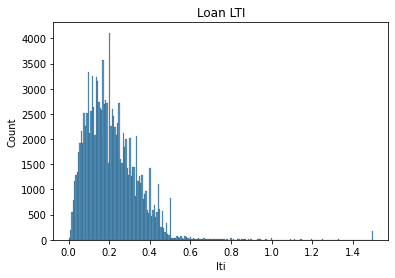

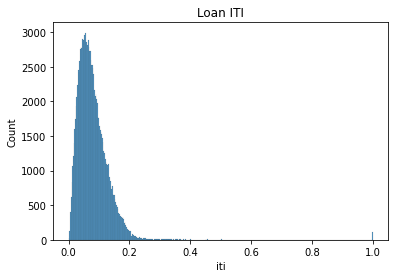

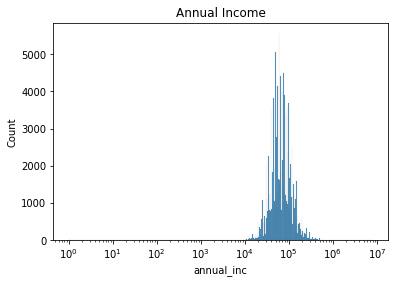

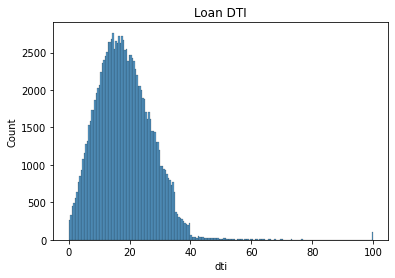

In [18]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()

In [19]:
df.dti.describe()

count    124550.000000
mean         18.291462
std           9.261819
min           0.000000
25%          11.720000
50%          17.570000
75%          24.070000
max         100.000000
Name: dti, dtype: float64

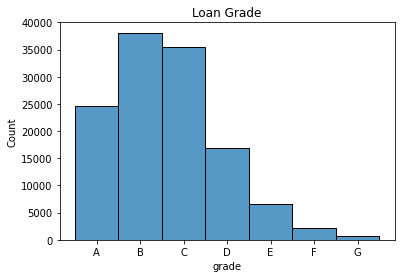

In [20]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')
plt.show()

### EDA with target

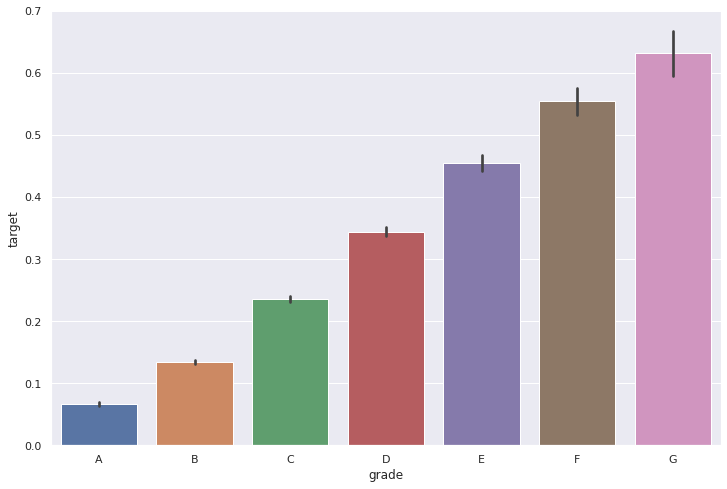

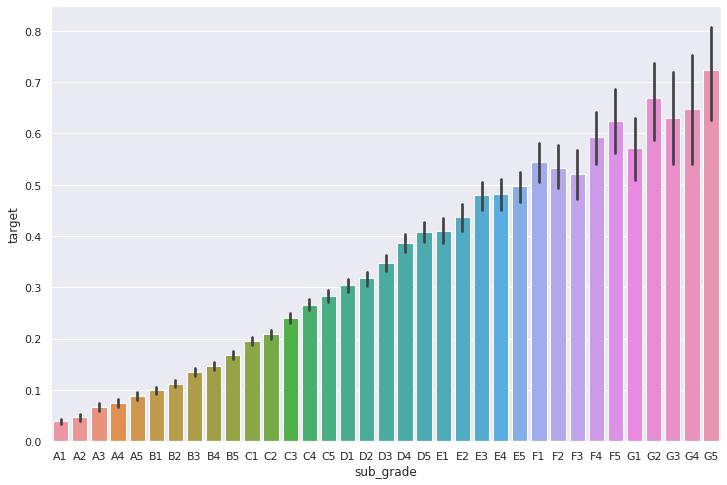

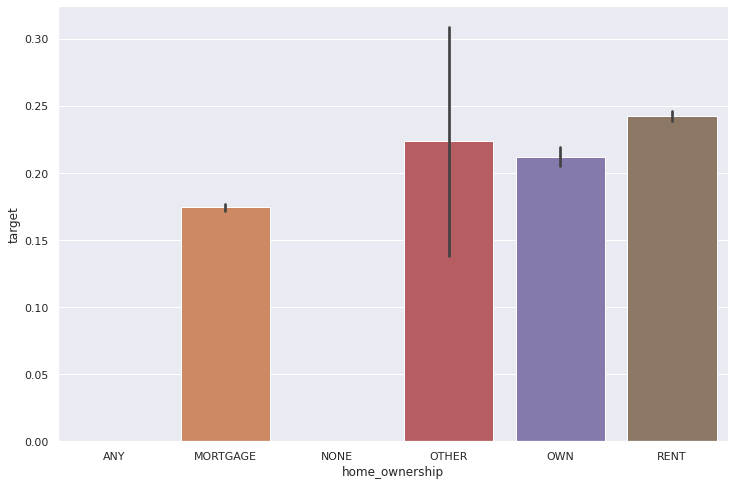

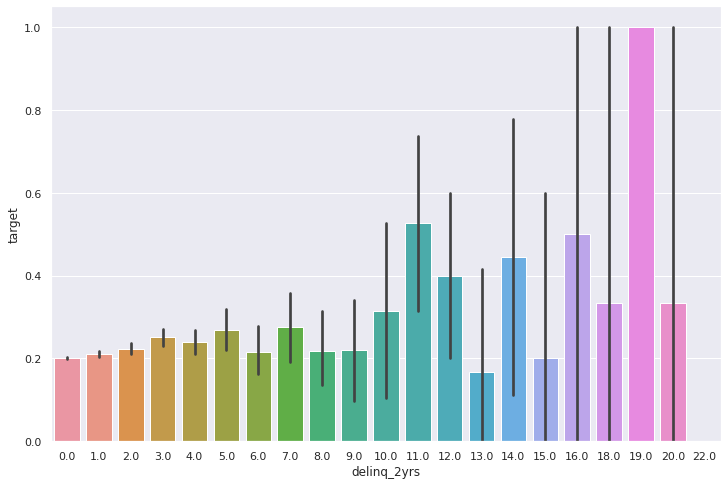

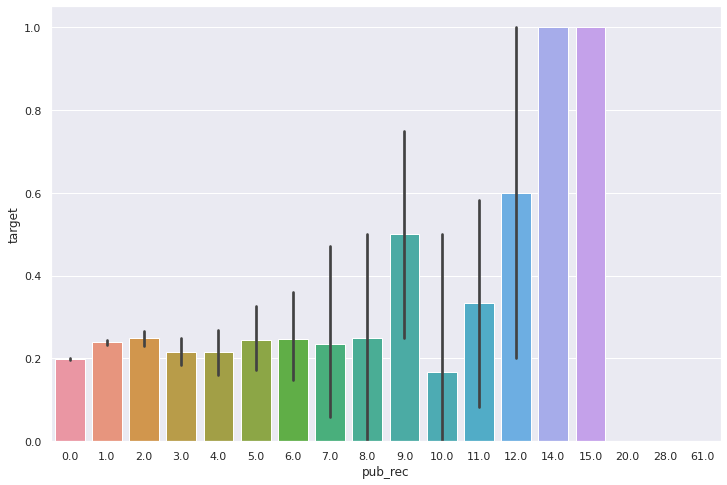

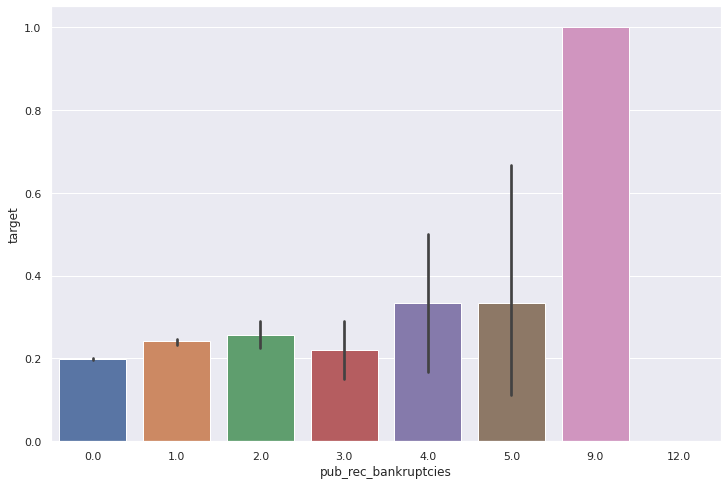

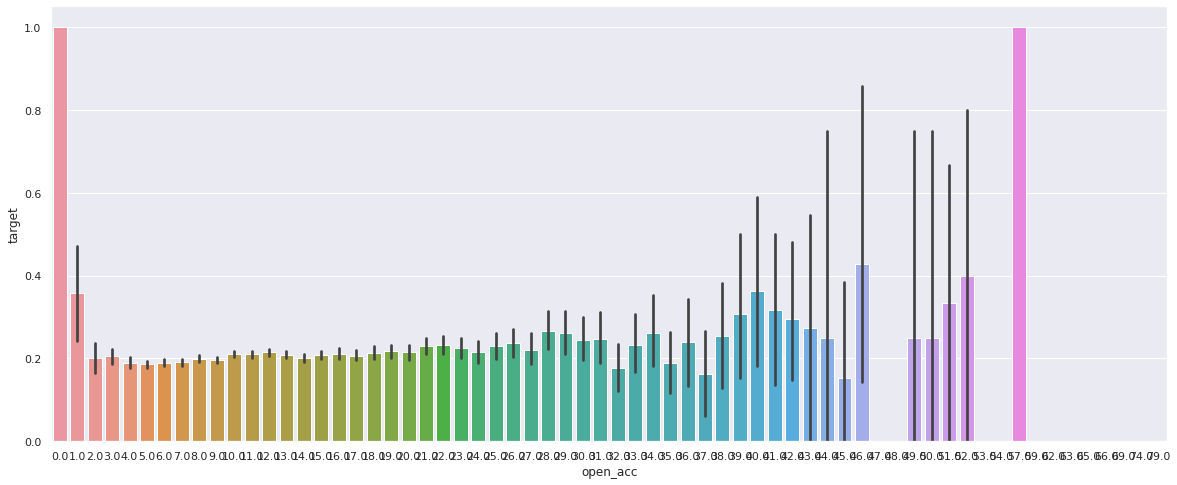

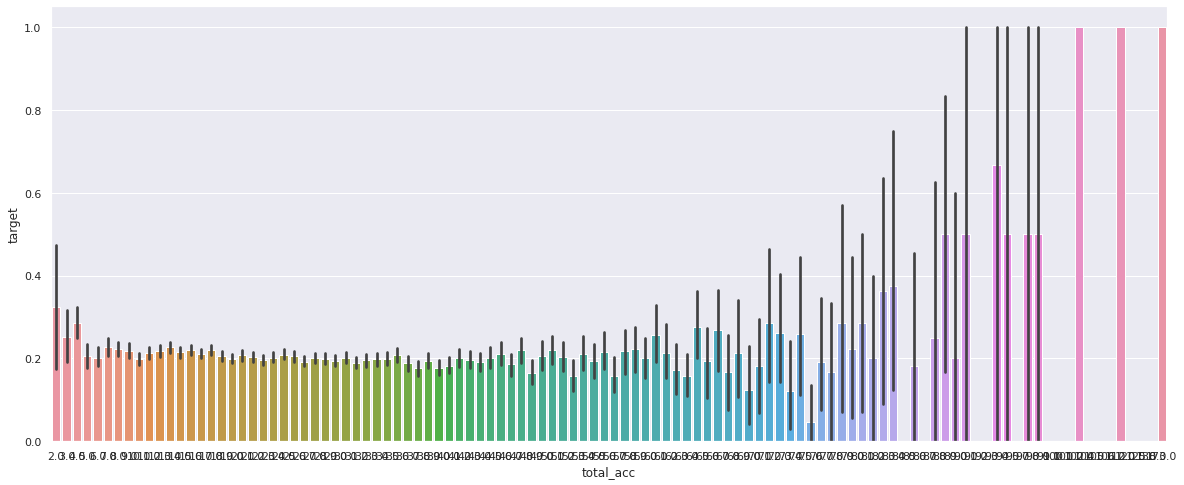

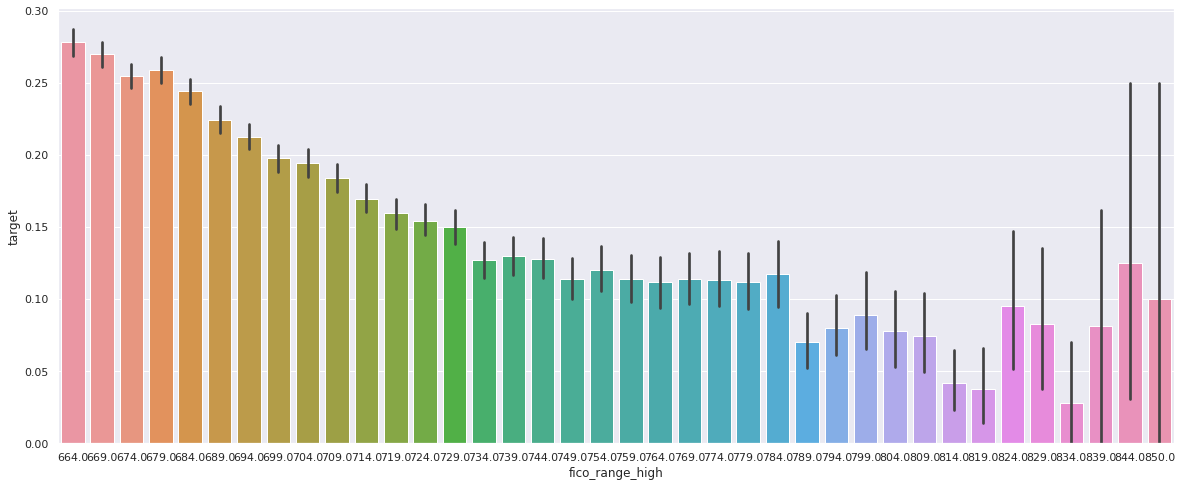

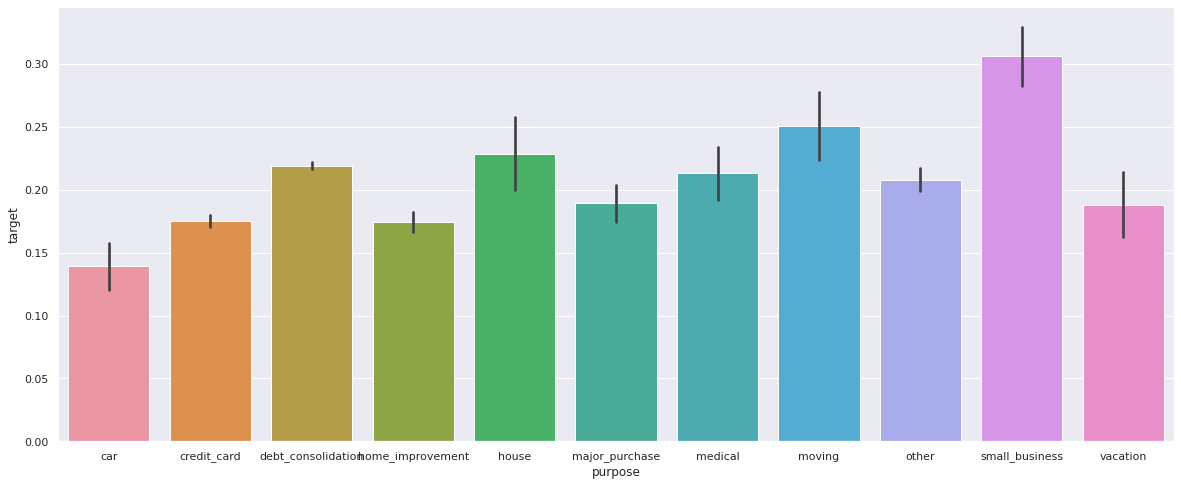

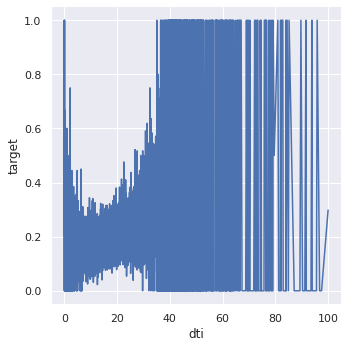

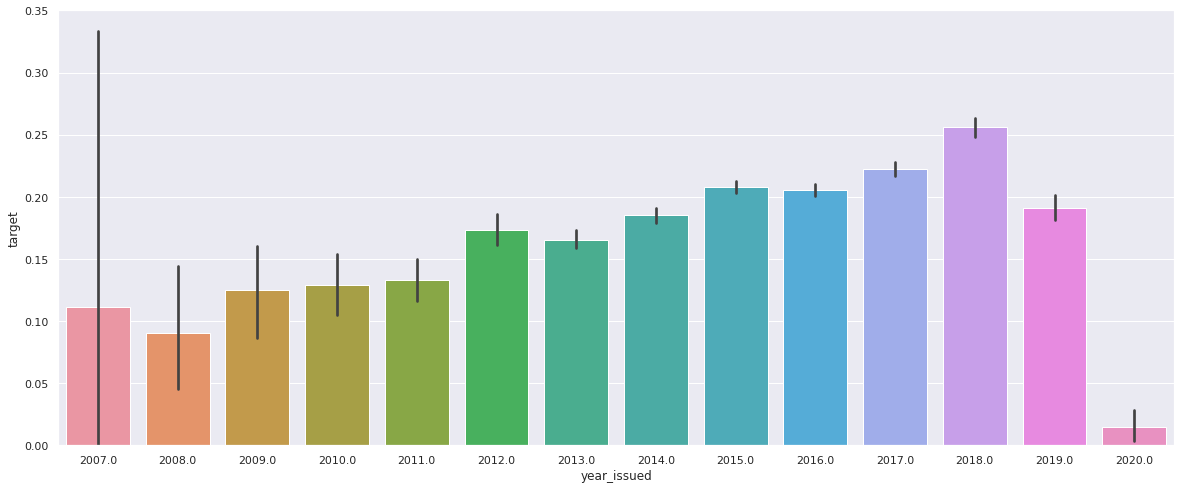

In [21]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.relplot(x='dti', y='target', data=df, ci=None, kind = 'line')
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

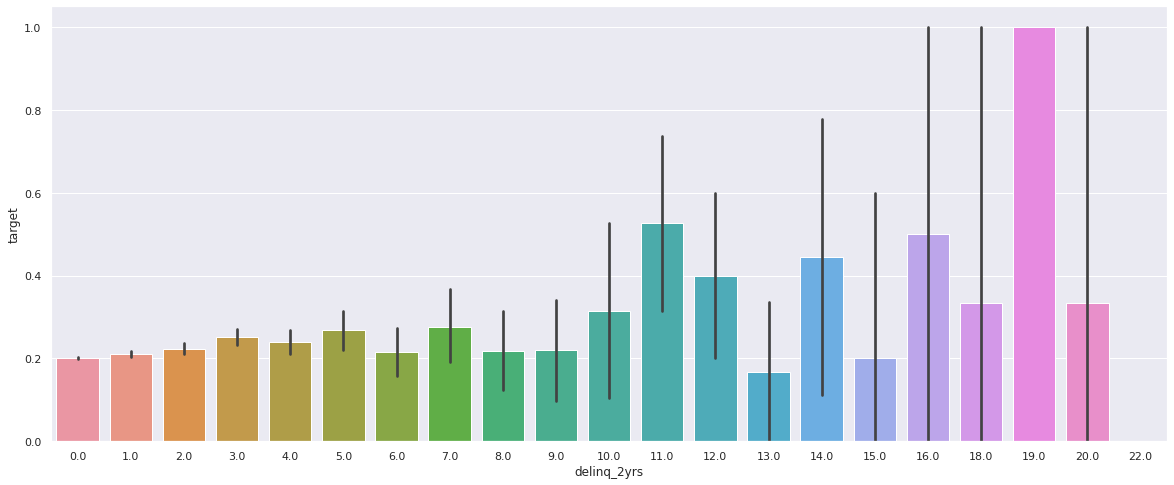

In [22]:
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()

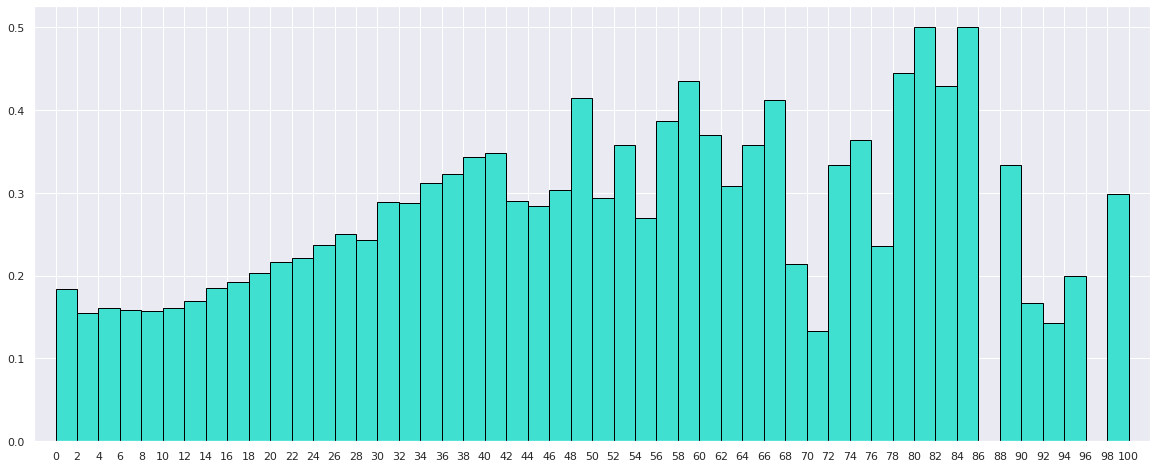

In [23]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) # 10 bins, so 11 bin boundaries
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

### 5. Train-test split, missing values and feature engineering

In this section I fill missing values from train set and encode categorical features.

Depending of feature type, I use three encoding types:

- Target encoding. I do it for feature with more than 5 unique values.
- One-hot encoding. I use it for features with less than 5 unique values.
- Frequency encoding. 'Title' feature only.

In [24]:
display(df.count())

id                                124609
loan_amnt                         124609
funded_amnt                       124609
funded_amnt_inv                   124609
term                              124609
int_rate                          124609
installment                       124609
purpose                           124609
title                             123172
initial_list_status               124609
application_type                  124609
grade                             124609
sub_grade                         124609
fico_range_high                   124609
emp_title                         115958
emp_length                        116868
home_ownership                    124609
annual_inc                        124609
zip_code                          124609
addr_state                        124609
dti                               124550
verification_status               124609
mo_sin_rcnt_tl                    124609
mths_since_last_delinq            124609
mths_since_last_

In [25]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 
                     'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'bc_open_to_buy','tot_cur_bal_inc', 'total_rev_inc',
                    'total_bal_ex_mort_inc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75']
features_fill_zero = ['open_rv_12m', 'open_il_12m', 'emp_length', 'num_tl_90g_dpd_24m', 
                      'num_tl_30dpd', 'num_tl_120dpd_2m', 'num_accts_ever_120_pd',
                     'acc_open_past_24mths']

for col in features_fill_zero:
    df[col] = df[col].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')
    
test_size = 0.25
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
test00 = test.copy()
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())
    
df['total_cur_bal'] = df.tot_cur_bal_inc.median()*df.annual_inc
df['total_rev_hi_lim'] = df.total_rev_inc.median()*df.annual_inc
df['total_bal_ex_mort'] = df.total_bal_ex_mort_inc.median()*df.annual_inc


display(train.count())

(93457, 77)

(31152, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,20000.0,20000.0,20000.0,60.0,14.85,474.230011,debt_consolidation,Debt consolidation,w,Individual,C,C5,684.0,Project Manager,2.0,RENT,60000.0,770,TX,10.75,Not Verified,16.0,9.0,9.0,1200.0,24.0,9.0,0.0,0.0,3.0,2.0,13.0,3.0,2.0,55.0,1806.0,23476.0,2221.0,32.7,4126.0,28.0,2.0,3.0,6800.0,2.0,0.0,0.0,0.0,0.0,23476.0,0.0,0.0,50.000000,83.599998,0.0,0.0,1.0,0.0,0.0,6.0,2016.0,1.0,2016.0,17.752589,0.000000,1.0,0.333333,0.094846,0,0.037017,0.030100,0.391267,0.391267,0.113333,0,0.236364,0
1,10000.0,10000.0,10000.0,36.0,11.99,332.100006,credit_card,Credit card refinancing,w,Individual,C,C1,679.0,management,10.0,RENT,60000.0,231,VA,10.54,Source Verified,2.0,12.0,41.0,37.0,12.0,12.0,3.0,1.0,0.0,1.0,7.0,3.0,0.0,20.0,1947.0,13631.0,5938.0,40.7,2660.0,2.0,6.0,6.0,14600.0,2.0,0.0,0.0,3.0,0.0,13631.0,71.0,1.0,33.299999,52.599998,1.0,2.0,0.0,0.0,0.0,0.0,2016.0,2.0,2016.0,15.920929,0.188431,0.0,0.166667,0.066420,0,0.098967,0.032450,0.227183,0.227183,0.243333,0,0.350000,0
2,25000.0,25000.0,25000.0,36.0,6.68,768.280029,debt_consolidation,Debt consolidation,w,Individual,A,A3,744.0,Dir/Mar/sale,10.0,OWN,210000.0,301,GA,2.99,Source Verified,13.0,11.0,1200.0,1200.0,11.0,11.0,0.0,0.0,0.0,0.0,20.0,4.0,21.0,55.0,45327.0,906531.0,157526.0,23.8,35680.0,23.0,5.0,12.0,203400.0,1.0,0.0,0.0,0.0,0.0,157526.0,0.0,0.0,11.100000,98.099998,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,3.0,2015.0,15.666304,0.000000,0.0,0.119048,0.043902,0,0.750124,0.215843,4.316814,0.750124,0.968571,0,0.363636,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,5500.0,5500.0,5500.0,36.0,9.80,176.960007,credit_card,Credit card refinancing,w,Individual,B,B3,704.0,School Counselor,4.0,OWN,40000.0,457,WV,18.360001,Not Verified,4.0,0.0,1200.0,1200.0,0.0,0.0,5.0,3.0,1.0,5.0,16.0,8.0,3.0,44.0,12575.0,163476.0,2437.0,6.9,21244.0,4.0,2.0,13.0,35400.0,2.0,1.0,156.0,0.0,0.0,55446.0,0.0,0.0,0.0,95.300003,5.0,0.0,0.0,1.0,0.0,0.0,2015.0,12.0,2015.0,15.247404,0.0,0.0,0.137500,0.053088,0,0.060925,0.314375,4.086900,1.386150,0.885000,0,0.363636,0
1,26400.0,26400.0,26400.0,36.0,20.00,981.119995,debt_consolidation,Debt consolidation,w,Individual,D,D4,679.0,Sales,5.0,RENT,90000.0,27,MA,7.640000,Source Verified,2.0,81.0,1200.0,1200.0,1200.0,1200.0,4.0,0.0,0.0,1.0,8.0,7.0,0.0,10.0,3040.0,24319.0,12471.0,35.5,19991.0,4.0,5.0,7.0,35100.0,0.0,0.0,0.0,0.0,0.0,24319.0,1454.0,0.0,25.0,90.000000,3.0,1.0,0.0,0.0,0.0,0.0,2017.0,12.0,2017.0,14.587569,0.0,1.0,0.293333,0.130816,0,0.138567,0.033778,0.270211,0.270211,0.390000,0,0.800000,0
2,19200.0,19200.0,19200.0,60.0,26.24,577.590027,debt_consolidation,Debt consolidation,f,Individual,E,E5,714.0,Human Resouces Generalist,0.0,MORTGAGE,56500.0,337,FL,18.879999,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,0.0,1.0,0.0,10.0,5.0,2.0,11.0,12848.0,128478.0,20980.0,36.4,28393.0,3.0,7.0,8.0,57700.0,0.0,0.0,0.0,0.0,0.0,37649.0,0.0,0.0,40.0,100.000000,1.0,1.0,0.0,0.0,0.0,0.0,2016.0,10.0,2016.0,23.168169,0.0,0.0,0.339823,0.122674,0,0.371327,0.227398,2.273947,0.666354,1.021239,0,0.909091,0


loan_amnt                         93457
funded_amnt                       93457
funded_amnt_inv                   93457
term                              93457
int_rate                          93457
installment                       93457
purpose                           93457
title                             93457
initial_list_status               93457
application_type                  93457
grade                             93457
sub_grade                         93457
fico_range_high                   93457
emp_title                         93457
emp_length                        93457
home_ownership                    93457
annual_inc                        93457
zip_code                          93457
addr_state                        93457
dti                               93457
verification_status               93457
mo_sin_rcnt_tl                    93457
mths_since_last_delinq            93457
mths_since_last_major_derog       93457
mths_since_last_record            93457


In [26]:
train.percent_bc_gt_75.describe()

count    93457.000000
mean        42.647541
std         35.538868
min          0.000000
25%          0.000000
50%         40.000000
75%         66.699997
max        100.000000
Name: percent_bc_gt_75, dtype: float64

### Categorical features encoding

In [27]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

freq_enc = (train.groupby('title').size()) / len(train)
train['title_fencoded'] = train['title'].apply(lambda x : freq_enc[x])
test['title_fencoded'] = test['title'].apply(lambda x : freq_enc[x])

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

44.314844846725464

3.2300920486450195

(93457, 78)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,20000.0,20000.0,20000.0,60.0,14.85,474.230011,w,Individual,684.0,2.0,60000.0,10.750000,Not Verified,16.0,9.0,9.0,1200.0,24.0,9.0,0.0,0.0,3.0,2.0,13.0,3.0,2.0,55.0,1806.0,23476.0,2221.0,32.7,4126.0,28.0,2.0,3.0,6800.0,2.0,0.0,0.0,0.0,0.0,23476.0,0.0,0.0,50.000000,83.599998,0.0,0.0,1.0,0.0,0.0,6.0,2016.0,1.0,2016.0,17.752589,0.000000,1.0,0.333333,0.094846,0,0.037017,0.030100,0.391267,0.391267,0.113333,0,0.236364,0,0.502338,0.283556,0.175348,0.217585,0.223626,0.204195,0.199291,0.234617,0.240968
1,10000.0,10000.0,10000.0,36.0,11.99,332.100006,w,Individual,679.0,10.0,60000.0,10.540000,Source Verified,2.0,12.0,41.0,37.0,12.0,12.0,3.0,1.0,0.0,1.0,7.0,3.0,0.0,20.0,1947.0,13631.0,5938.0,40.7,2660.0,2.0,6.0,6.0,14600.0,2.0,0.0,0.0,3.0,0.0,13631.0,71.0,1.0,33.299999,52.599998,1.0,2.0,0.0,0.0,0.0,0.0,2016.0,2.0,2016.0,15.920929,0.188431,0.0,0.166667,0.066420,0,0.098967,0.032450,0.227183,0.227183,0.243333,0,0.350000,0,0.198615,0.191672,0.229099,0.177338,0.182376,0.303121,0.208945,0.234617,0.240968
2,25000.0,25000.0,25000.0,36.0,6.68,768.280029,w,Individual,744.0,10.0,210000.0,2.990000,Source Verified,13.0,11.0,1200.0,1200.0,11.0,11.0,0.0,0.0,0.0,0.0,20.0,4.0,21.0,55.0,45327.0,906531.0,157526.0,23.8,35680.0,23.0,5.0,12.0,203400.0,1.0,0.0,0.0,0.0,0.0,157526.0,0.0,0.0,11.100000,98.099998,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,3.0,2015.0,15.666304,0.000000,0.0,0.119048,0.043902,0,0.750124,0.215843,4.316814,0.750124,0.968571,0,0.363636,0,0.502338,0.068287,0.204018,0.217585,0.223626,0.183956,0.198639,0.064253,0.211732
3,13000.0,13000.0,13000.0,60.0,18.24,331.820007,w,Individual,709.0,5.0,65000.0,26.940001,Source Verified,2.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,21.0,2.0,0.0,45.0,4016.0,84338.0,2745.0,70.4,1155.0,35.0,3.0,3.0,3900.0,0.0,0.0,0.0,0.0,0.0,84338.0,0.0,0.0,33.299999,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,10.0,2014.0,11.915371,0.000000,0.0,0.200000,0.061259,0,0.042231,0.061785,1.297508,1.297508,0.060000,0,0.466667,0,0.010775,0.397832,0.136012,0.217335,0.219790,0.231853,0.201244,0.343987,0.240968
4,24200.0,24200.0,24200.0,36.0,9.49,775.090027,f,Individual,664.0,8.0,72000.0,22.120001,Verified,28.0,1200.0,1200.0,82.0,1200.0,1200.0,0.0,0.0,0.0,0.0,17.0,0.0,2.0,30.0,8413.0,126193.0,25014.0,85.4,0.0,28.0,11.0,15.0,29300.0,0.0,0.0,0.0,1.0,1.0,33516.0,0.0,0.0,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,11.0,2014.0,40.833145,0.024490,0.0,0.336111,0.129182,0,0.347417,0.116847,1.752681,0.465500,0.406944,0,0.566667,1,0.198615,0.117981,0.304930,0.177338,0.182376,0.154632,0.204337,0.135146,0.173806


loan_amnt                         93457
funded_amnt                       93457
funded_amnt_inv                   93457
term                              93457
int_rate                          93457
installment                       93457
initial_list_status               93457
application_type                  93457
fico_range_high                   93457
emp_length                        93457
annual_inc                        93457
dti                               93457
verification_status               93457
mo_sin_rcnt_tl                    93457
mths_since_last_delinq            93457
mths_since_last_major_derog       93457
mths_since_last_record            93457
mths_since_recent_bc_dlq          93457
mths_since_recent_revol_delinq    93457
num_tl_op_past_12m                93457
inq_last_6mths                    93457
inq_fi                            93457
inq_last_12m                      93457
open_acc                          93457
acc_open_past_24mths              93457


In [28]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_train.columns = X_train.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
X_test.columns = X_test.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
#X_train.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_train.columns]
#X_test.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_test.columns]

print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,5500.0,5500.0,5500.0,36.0,9.80,176.960007,w,Individual,704.0,4.0,40000.0,18.360001,Not Verified,4.0,0.0,1200.0,1200.0,0.0,0.0,5.0,3.0,1.0,5.0,16.0,8.0,3.0,44.0,12575.0,163476.0,2437.0,6.9,21244.0,4.0,2.0,13.0,35400.0,2.0,1.0,156.0,0.0,0.0,55446.0,0.0,0.0,0.0,95.300003,5.0,0.0,0.0,1.0,0.0,0.0,2015.0,12.0,2015.0,15.247404,0.0,0.137500,0.053088,0,0.060925,0.314375,4.086900,1.386150,0.885000,0,0.363636,0,0.198615,0.135854,0.184864,0.176476,0.181733,0.126035,0.165455,0.134104,0.214719
1,26400.0,26400.0,26400.0,36.0,20.00,981.119995,w,Individual,679.0,5.0,90000.0,7.640000,Source Verified,2.0,81.0,1200.0,1200.0,1200.0,1200.0,4.0,0.0,0.0,1.0,8.0,7.0,0.0,10.0,3040.0,24319.0,12471.0,35.5,19991.0,4.0,5.0,7.0,35100.0,0.0,0.0,0.0,0.0,0.0,24319.0,1454.0,0.0,25.0,90.000000,3.0,1.0,0.0,0.0,0.0,0.0,2017.0,12.0,2017.0,14.587569,0.0,0.293333,0.130816,0,0.138567,0.033778,0.270211,0.270211,0.390000,0,0.800000,0,0.502338,0.384594,0.211169,0.218509,0.223926,0.186651,0.197082,0.344626,0.241982
2,19200.0,19200.0,19200.0,60.0,26.24,577.590027,f,Individual,714.0,0.0,56500.0,18.879999,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,0.0,1.0,0.0,10.0,5.0,2.0,11.0,12848.0,128478.0,20980.0,36.4,28393.0,3.0,7.0,8.0,57700.0,0.0,0.0,0.0,0.0,0.0,37649.0,0.0,0.0,40.0,100.000000,1.0,1.0,0.0,0.0,0.0,0.0,2016.0,10.0,2016.0,23.168169,0.0,0.339823,0.122674,0,0.371327,0.227398,2.273947,0.666354,1.021239,0,0.909091,0,0.502338,0.505970,0.204468,0.218509,0.223926,0.251485,0.230132,0.451250,0.173323
3,9600.0,9600.0,9600.0,36.0,11.55,316.799988,w,Individual,699.0,9.0,89250.0,30.049999,Verified,3.0,16.0,1200.0,1200.0,30.0,30.0,4.0,2.0,0.0,5.0,15.0,8.0,3.0,28.0,38996.0,584954.0,97755.0,81.0,5921.0,3.0,11.0,11.0,121105.0,1.0,0.0,0.0,0.0,0.0,76322.0,0.0,0.0,20.0,86.000000,3.0,1.0,0.0,0.0,0.0,0.0,2018.0,7.0,2018.0,29.410597,0.0,0.107563,0.042595,0,1.095294,0.436930,6.554106,0.855148,1.356919,0,0.535714,0,0.502338,0.149183,0.219093,0.218509,0.223926,0.168112,0.216689,0.134104,0.173323
4,30000.0,30000.0,30000.0,60.0,14.49,705.700012,w,Individual,704.0,2.0,122000.0,9.210000,Source Verified,4.0,8.0,26.0,1200.0,29.0,29.0,2.0,1.0,9.0,6.0,25.0,4.0,2.0,66.0,18137.0,380875.0,17078.0,41.8,9947.0,4.0,7.0,19.0,40900.0,2.0,0.0,0.0,0.0,0.0,131718.0,0.0,0.0,0.0,82.800003,2.0,0.0,0.0,0.0,0.0,1.0,2016.0,8.0,2016.0,18.086614,0.0,0.245902,0.069413,0,0.139984,0.148664,3.121926,1.079656,0.335246,0,0.378788,0,0.502338,0.267255,0.157749,0.218509,0.223926,0.187590,0.196044,0.235421,0.214719


Number of features before transaformation:  (93457, 77)
time to do feature proprocessing:  3.693079710006714
Number of features after transaformation:  (93457, 79)


,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,fico_range_high,emp_length,annual_inc,dti,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,1.0,0.0,0.0,1.0,0.0,20000.0,20000.0,20000.0,60.0,14.85,474.230011,684.0,2.0,60000.0,10.750000,16.0,9.0,9.0,1200.0,24.0,9.0,0.0,0.0,3.0,2.0,13.0,3.0,2.0,55.0,1806.0,23476.0,2221.0,32.7,4126.0,28.0,2.0,3.0,6800.0,2.0,0.0,0.0,0.0,0.0,23476.0,0.0,0.0,50.000000,83.599998,0.0,0.0,1.0,0.0,0.0,6.0,2016.0,1.0,2016.0,17.752589,0.000000,0.333333,0.094846,0.0,0.037017,0.030100,0.391267,0.391267,0.113333,0.0,0.236364,0.0,0.502338,0.283556,0.175348,0.217585,0.223626,0.204195,0.199291,0.234617,0.240968
1,0.0,1.0,0.0,1.0,0.0,10000.0,10000.0,10000.0,36.0,11.99,332.100006,679.0,10.0,60000.0,10.540000,2.0,12.0,41.0,37.0,12.0,12.0,3.0,1.0,0.0,1.0,7.0,3.0,0.0,20.0,1947.0,13631.0,5938.0,40.7,2660.0,2.0,6.0,6.0,14600.0,2.0,0.0,0.0,3.0,0.0,13631.0,71.0,1.0,33.299999,52.599998,1.0,2.0,0.0,0.0,0.0,0.0,2016.0,2.0,2016.0,15.920929,0.188431,0.166667,0.066420,0.0,0.098967,0.032450,0.227183,0.227183,0.243333,0.0,0.350000,0.0,0.198615,0.191672,0.229099,0.177338,0.182376,0.303121,0.208945,0.234617,0.240968
2,0.0,1.0,0.0,1.0,0.0,25000.0,25000.0,25000.0,36.0,6.68,768.280029,744.0,10.0,210000.0,2.990000,13.0,11.0,1200.0,1200.0,11.0,11.0,0.0,0.0,0.0,0.0,20.0,4.0,21.0,55.0,45327.0,906531.0,157526.0,23.8,35680.0,23.0,5.0,12.0,203400.0,1.0,0.0,0.0,0.0,0.0,157526.0,0.0,0.0,11.100000,98.099998,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,3.0,2015.0,15.666304,0.000000,0.119048,0.043902,0.0,0.750124,0.215843,4.316814,0.750124,0.968571,0.0,0.363636,0.0,0.502338,0.068287,0.204018,0.217585,0.223626,0.183956,0.198639,0.064253,0.211732
3,0.0,1.0,0.0,1.0,0.0,13000.0,13000.0,13000.0,60.0,18.24,331.820007,709.0,5.0,65000.0,26.940001,2.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,21.0,2.0,0.0,45.0,4016.0,84338.0,2745.0,70.4,1155.0,35.0,3.0,3.0,3900.0,0.0,0.0,0.0,0.0,0.0,84338.0,0.0,0.0,33.299999,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,10.0,2014.0,11.915371,0.000000,0.200000,0.061259,0.0,0.042231,0.061785,1.297508,1.297508,0.060000,0.0,0.466667,0.0,0.010775,0.397832,0.136012,0.217335,0.219790,0.231853,0.201244,0.343987,0.240968
4,0.0,0.0,1.0,0.0,0.0,24200.0,24200.0,24200.0,36.0,9.49,775.090027,664.0,8.0,72000.0,22.120001,28.0,1200.0,1200.0,82.0,1200.0,1200.0,0.0,0.0,0.0,0.0,17.0,0.0,2.0,30.0,8413.0,126193.0,25014.0,85.4,0.0,28.0,11.0,15.0,29300.0,0.0,0.0,0.0,1.0,1.0,33516.0,0.0,0.0,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,11.0,2014.0,40.833145,0.024490,0.336111,0.129182,0.0,0.347417,0.116847,1.752681,0.465500,0.406944,0.0,0.566667,1.0,0.198615,0.117981,0.304930,0.177338,0.182376,0.154632,0.204337,0.135146,0.173806


### 6. Modeling

Here I will build 2 models to predict loan bankruptcies:

- Baseline XGBoost model (default hyperparameters).
- XGBoost model with hyperparameter optimization using Optuna.

'Train Accuracy: '

0.8553238387707716

'F1 score: '

0.5135806022232615

'ROCAUC: '

0.6763466794148684

'PRAUC: '

0.7035427900512541

'R20P: '

0.9172264875239923

'Test Accuracy: '

0.8082948125321007

'F1 score: '

0.34025629695095005

'ROCAUC: '

0.5978549804024333

'PRAUC: '

0.4600972579729102

'R20P: '

0.617533718689788

5.1129209995269775

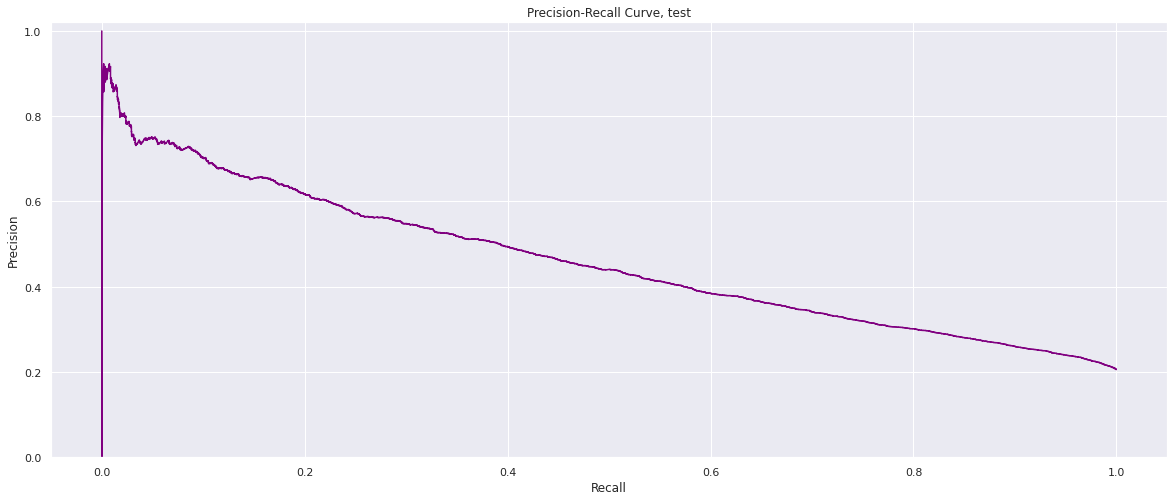

In [29]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

[I 2022-08-14 14:54:35,532] A new study created in memory with name: no-name-f467797c-5bed-4ee7-9b19-678d753e86ef
[I 2022-08-14 14:54:57,564] Trial 0 finished with value: 0.42873387012039443 and parameters: {'n_estimators': 1445, 'max_depth': 6, 'learning_rate': 0.19135225470125228, 'colsample_bytree': 0.6426569164719886, 'subsample': 0.8983297894890818, 'alpha': 0.1569761401490956, 'lambda': 40.717239688160504, 'gamma': 3.03936657902183e-07, 'min_child_weight': 0.3335321106650721}. Best is trial 0 with value: 0.42873387012039443.
[I 2022-08-14 14:55:08,393] Trial 1 finished with value: 0.44758913639947406 and parameters: {'n_estimators': 949, 'max_depth': 5, 'learning_rate': 0.07640446593951031, 'colsample_bytree': 0.7354535063436982, 'subsample': 0.6017635362708663, 'alpha': 0.1827011183501306, 'lambda': 0.17492715562605152, 'gamma': 5.25761599903143e-08, 'min_child_weight': 0.5458200140697572}. Best is trial 1 with value: 0.44758913639947406.
[I 2022-08-14 14:55:21,619] Trial 2 fini

Total time for hypermarameter optimization  512.6229646205902
        n_estimators : 1417
           max_depth : 4
       learning_rate : 0.01497872958984062
    colsample_bytree : 0.5985250112372502
           subsample : 0.6075102110681543
               alpha : 0.19396922794007768
              lambda : 7.017618357688308
               gamma : 1.1040651573360095e-07
    min_child_weight : 4.314252963690138
best objective value : 0.4765889613720516


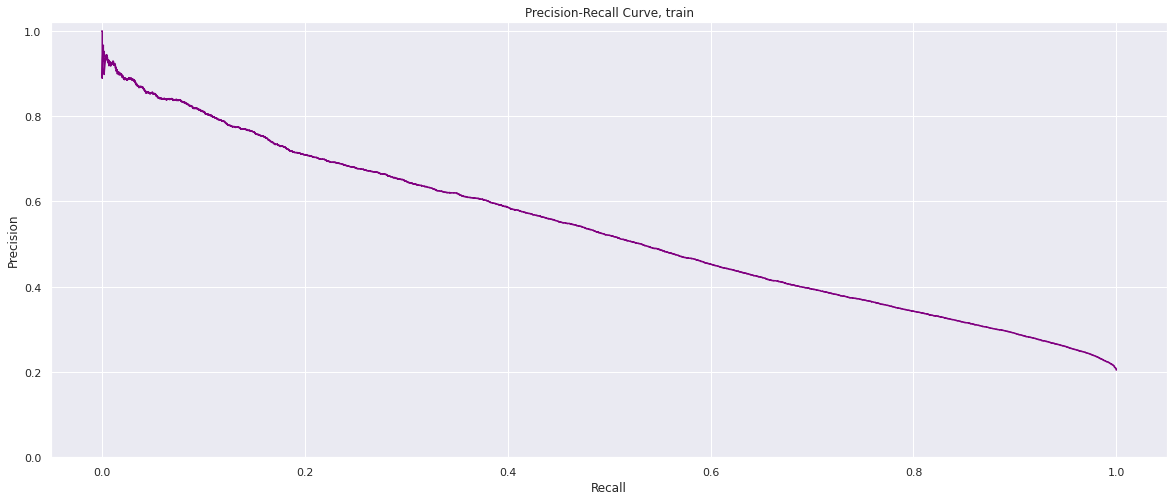

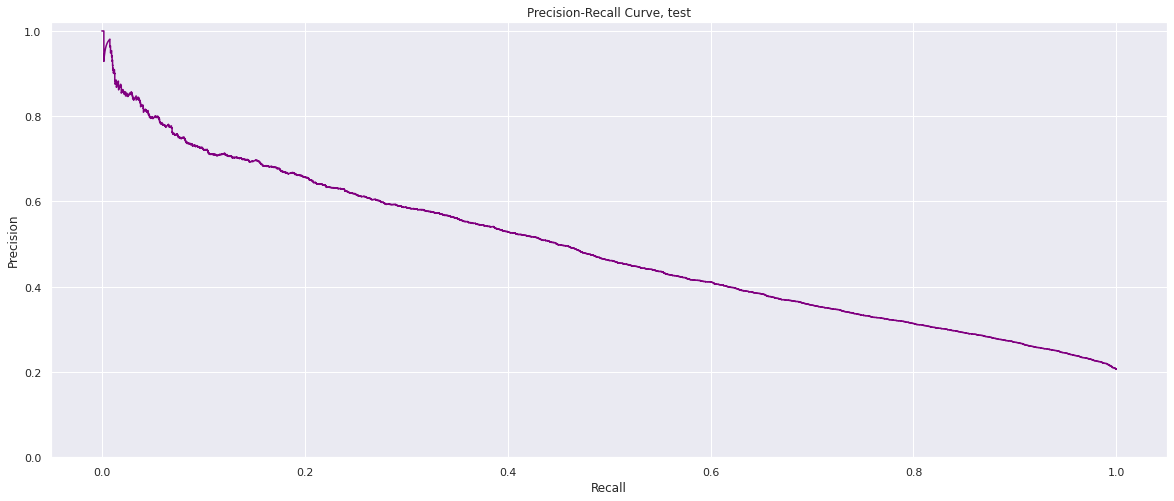

'Train Accuracy: '

0.8218646008324684

'F1 score: '

0.3498398812778255

'ROCAUC: '

0.6036247723306308

'PRAUC: '

0.5323291293713334

'R20P: '

0.7093477048875674

'Test Accuracy: '

0.8138482280431433

'F1 score: '

0.32640260192821463

'ROCAUC: '

0.5935487932814539

'PRAUC: '

0.4867732858373712

'R20P: '

0.6567774936061381

'Time to do hyperparameter optimization: '

528.3900547027588

In [30]:
### Fit XGBoost using Optuna hyperparameter optimization ###

time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=2):

    cv_regularizer=0.01
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.25),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict_proba(X_B)[:, 1]
            #y_pred_train[train_index] += model.predict_proba(X_A)[:, 1]
                      
        #precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred_train)
        #score_train = auc(recall_t, precision_t)
        precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred)
        score_test = auc(recall_t, precision_t)
            
        #score_train = roc_auc_score(y_train, y_pred_train)
        #score_test = roc_auc_score(y_train, y_pred) 
        #overfit = score_train-score_test
        #temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display('Time to do hyperparameter optimization: ', time.time()-time1)

### 7. Model interpretation

In [31]:
#results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
#fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
#fi = fi.sort_values('FI', ascending = False)

#display(fi)

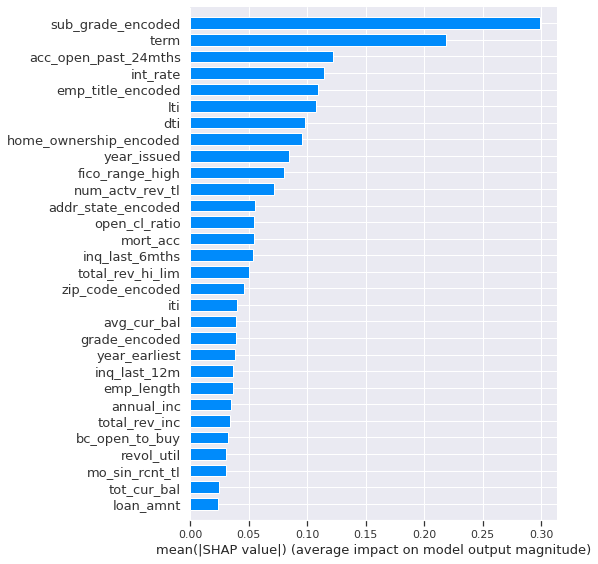

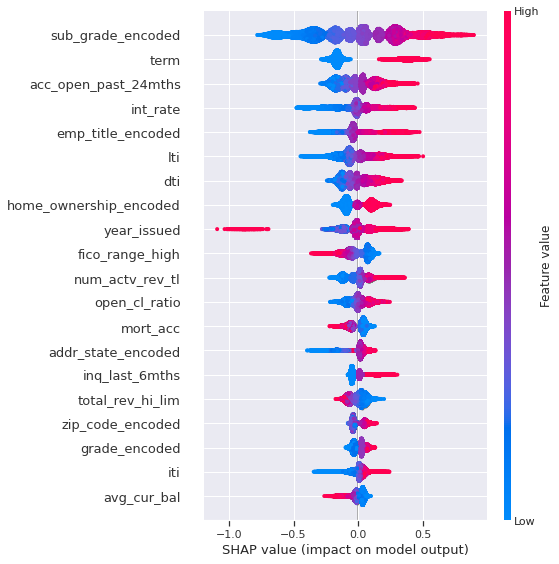

In [32]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
#display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)
shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [33]:
#indx = 1
#fig = plt.subplots(figsize=(6,6),dpi=200)
#ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

#shap.initjs()
#shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

In [34]:
time.time()-time0

595.720546245575

### 8. Business implications

#### 8.1 Is this model useful?

This project is a perfect illustration of how machine learning can create value if we think hard about business problem at hand rather than focusing on a few narrow model evaluation metrics.

If you view this project as a purely data mining and prediction problem, then it is arguably a failure. Model accuracy is 81% which barely beats 80% from a trivial model, always predicting no default. F1 score is only 34%, which is not impressive. ROCAUC is 59% which is not much better than a random guess.

However, the predictive model above can create value if used properly. Let me show how.

Precision-recall curve above shows that model is actually very good in predicting defaults for around one quarter of defaulted loans. For example, its precision at 20% recall is 69%. This means that if we use the model only to predict default for those loans it is most confident about, we can avoid at least 20% of credit losses while forgoing relatively few profitable lending opportunities. 

#### 8.2 How much value does it create?

To quantify value created by the model, I consider a problem faced by all Lending Club investors as a group to maximize their investment profit. They can do so by avoiding x% of the riskiest loans as determined by my model. In order to keep this analysis simple and accessible to wider audience I abstract away from time discounting and present value calculations.

The decision of an investor to avoid financing x% of the riskiest loans is a tradoeff between a foregone interest income and a credit loss. 

If investors invest in a loan:
- They receive interest income in the future as long as the borrower repays a loan.
- They suffer credit losses and receive only recovered amount if the borrower defaults.

So their total dollar return (TR) from investment is as follows:

$$ TR_{Invest} = \sum_{j \in RepaidLoans}LoanAmount_j*(r_j+1) + \sum_{k \in DefaultedLoans}Recovery_k.$$

Their outisde riskless option is to invest in Treasury bills with similar maturity. Average yield of 3-year treasury notes over this sample period [is around 2%](https://fred.stlouisfed.org/series/DGS3). So their TR if they forgo such loans is:

$$ TR_{Forgo} = \sum_{i \in AllLoans} LoanAmount_i*(1.02).$$

Thus the decision to issue such loans depends on which part dominates. Savings of investors from avoiding top x% riskiest loans are the difference between the returns fom investing in T-notes and LendingClub loans:

$$ \sum_{i \in AllLoans} LoanAmount_i*(1.02) - \sum_{j \in RepaidLoans}LoanAmount_j*(r_j+1) + \sum_{k \in DefaultedLoans}Recovery_k $$

The expression above is the value created from avoiding the riskiest loans. For example, if I use the model to identify top 20% riskiest loans, then AllLoans will be the loans with 20% of the highest predicted default probabilities. RepaidLoans and DefaultedLoans will be subsets of those loans.

The code below uses loan_amnt, int_rate and recovery features to calculate this value created:



In [43]:
X_test_0 = X_test.copy()
X_test['y_pred'] = optuna_xgb.predict_proba(X_test)[:,1]
X_test['id'] = test00.id
X_test = pd.merge(X_test, recoveries, on='id', how = 'left')
display(recoveries.head(), X_test.head())

ValueError: Feature shape mismatch, expected: 79, got 81

In [49]:
recoveries['rr'] = recoveries.recoveries/recoveries.loan_amnt
recoveries.rr.describe()

count    851132.000000
mean          0.010751
std           0.045732
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.218959
Name: rr, dtype: float64

In [47]:
test00

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,68202162,5500.0,5500.0,5500.0,36.0,9.80,176.960007,credit_card,Credit card refinancing,w,Individual,B,B3,704.0,School Counselor,4.0,OWN,40000.0,457,WV,18.360001,Not Verified,4.0,0.0,1200.0,1200.0,0.0,0.0,5.0,3.0,1.0,5.0,16.0,8.0,3.0,44.0,12575.0,163476.0,2437.0,6.9,21244.0,4.0,2.0,13.0,35400.0,2.0,1.0,156.0,0.0,0.0,55446.0,0.0,0.0,0.000000,95.300003,5.0,0.0,0.0,1.0,0.0,0.0,2015.0,12.0,2015.0,15.247404,0.000000,0.0,0.137500,0.053088,0,0.060925,0.314375,4.086900,1.386150,0.885000,0,0.363636,0
1,125883287,26400.0,26400.0,26400.0,36.0,20.00,981.119995,debt_consolidation,Debt consolidation,w,Individual,D,D4,679.0,Sales,5.0,RENT,90000.0,27,MA,7.640000,Source Verified,2.0,81.0,1200.0,1200.0,1200.0,1200.0,4.0,0.0,0.0,1.0,8.0,7.0,0.0,10.0,3040.0,24319.0,12471.0,35.5,19991.0,4.0,5.0,7.0,35100.0,0.0,0.0,0.0,0.0,0.0,24319.0,1454.0,0.0,25.000000,90.000000,3.0,1.0,0.0,0.0,0.0,0.0,2017.0,12.0,2017.0,14.587569,0.000000,1.0,0.293333,0.130816,0,0.138567,0.033778,0.270211,0.270211,0.390000,0,0.800000,0
2,91684030,19200.0,19200.0,19200.0,60.0,26.24,577.590027,debt_consolidation,Debt consolidation,f,Individual,E,E5,714.0,Human Resouces Generalist,0.0,MORTGAGE,56500.0,337,FL,18.879999,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,0.0,1.0,0.0,10.0,5.0,2.0,11.0,12848.0,128478.0,20980.0,36.4,28393.0,3.0,7.0,8.0,57700.0,0.0,0.0,0.0,0.0,0.0,37649.0,0.0,0.0,40.000000,100.000000,1.0,1.0,0.0,0.0,0.0,0.0,2016.0,10.0,2016.0,23.168169,0.000000,0.0,0.339823,0.122674,0,0.371327,0.227398,2.273947,0.666354,1.021239,0,0.909091,0
3,137470159,9600.0,9600.0,9600.0,36.0,11.55,316.799988,debt_consolidation,Debt consolidation,w,Individual,B,B4,699.0,Manager,9.0,MORTGAGE,89250.0,208,MD,30.049999,Verified,3.0,16.0,1200.0,1200.0,30.0,30.0,4.0,2.0,0.0,5.0,15.0,8.0,3.0,28.0,38996.0,584954.0,97755.0,81.0,5921.0,3.0,11.0,11.0,121105.0,1.0,0.0,0.0,0.0,0.0,76322.0,0.0,0.0,20.000000,86.000000,3.0,1.0,0.0,0.0,0.0,0.0,2018.0,7.0,2018.0,29.410597,0.000000,0.0,0.107563,0.042595,0,1.095294,0.436930,6.554106,0.855148,1.356919,0,0.535714,0
4,88132642,30000.0,30000.0,30000.0,60.0,14.49,705.700012,debt_consolidation,Debt consolidation,w,Individual,C,C4,704.0,APRN,2.0,OWN,122000.0,406,KY,9.210000,Source Verified,4.0,8.0,26.0,1200.0,29.0,29.0,2.0,1.0,9.0,6.0,25.0,4.0,2.0,66.0,18137.0,380875.0,17078.0,41.8,9947.0,4.0,7.0,19.0,40900.0,2.0,0.0,0.0,0.0,0.0,131718.0,0.0,0.0,0.000000,82.800003,2.0,0.0,0.0,0.0,0.0,1.0,2016.0,8.0,2016.0,18.086614,0.000000,1.0,0.245902,0.069413,0,0.139984,0.148664,3.121926,1.079656,0.335246,0,0.378788,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31147,66622835,8500.0,8500.0,8500.0,36.0,7.89,265.929993,debt_consolidation,Debt consolidatio